In [1]:
# read take the model, read the directory, usmein baki models, and then run 5 - 5 examples of each of the two from all of them , run CKA on the 
# extracted embeddings  

In [2]:
import os
from transformers import AutoModel, AutoImageProcessor
import torch
import pandas as pd
from PIL import Image
import random
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm


In [3]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

def clear_memory():
    """
    Clears Python and CUDA memory to free up resources.
    """
    gc.collect()  # Trigger garbage collection
    if torch.cuda.is_available() and device == 'cuda':
        torch.cuda.empty_cache()  # Empty CUDA cache if available 

Using GPU: NVIDIA GeForce GTX 1650


In [5]:

model_name  = 'facebook/vit-msn-base-4'
layers = 1
number = 1
base_dir = f"/visual_data/yangzhao/point/EMNLP2024/layer_fus/al/{model_name}/fused_{number}_layers/iteration/merged_weights/"
val_csv = r"..\val_csv"
val_images = r"..\val_images"

classA = 'n07920052'
classB = 'n01484850'
num_images = 25
global tokenizer

random.seed(42)


In [6]:
#temp
base_dir=r"C:\visual_data\yangzhao\point\EMNLP2024\layer_fus\al\vit-msn-base-4\fused_1_layers\iteration\merged_weights"


In [7]:
def centering(K):
    n = K.shape[0]
    data_type= K.dtype
    unit = torch.ones([n, n]).to(device, dtype=data_type)
    I = torch.eye(n).to(device, dtype=data_type)
    H = I - unit / n

    return ((H@ K)@ H)  # HKH are the same with KH, KH is the first centering, H(KH) do the second time, results are the sme with one time centering
    # return np.dot(H, K)  # KH


def rbf(X, sigma=None):
    GX = (X@ X.T).to(device)
    KX = torch.diag(GX) - GX + (torch.diag(GX) - GX).T
    if sigma is None:
        mdist = torch.median(KX[KX != 0])
        sigma = torch.sqrt(mdist)
    KX *= - 0.5 / (sigma * sigma)
    KX = torch.exp(KX).to(device)
    return KX


def kernel_HSIC(X, Y, sigma):
    return torch.sum(centering(rbf(X, sigma)) * centering(rbf(Y, sigma)))


def linear_HSIC(X, Y):
    L_X = (X@ X.T)
    L_Y = (Y@ Y.T)
    return torch.sum(centering(L_X) * centering(L_Y))


def linear_CKA(X, Y):
    hsic = linear_HSIC(X, Y)
    var1 = torch.sqrt(linear_HSIC(X, X))
    var2 = torch.sqrt(linear_HSIC(Y, Y))

    return hsic / (var1 * var2)


def kernel_CKA(X, Y, sigma=None):
    hsic = kernel_HSIC(X, Y, sigma)
    var1 = torch.sqrt(kernel_HSIC(X, X, sigma))
    var2 = torch.sqrt(kernel_HSIC(Y, Y, sigma))

    return hsic / (var1 * var2)



In [8]:
@torch.no_grad
def latent_embeddings_for_class(classA, num_images):
    cur_csv = os.path.join(val_csv , (classA+ '.csv'))
    df = pd.read_csv(cur_csv, header = None)
    embeddings = []
    for i in tqdm(range(num_images)):
        image_name = df.iloc[random.randint(1, 50), 0]
        image_path = os.path.join(val_images, image_name)
        image =Image.open(image_path)

        inputs = tokenizer(image, return_tensors="pt").to(device).to(torch.bfloat16)
        
        output = model(**inputs)
        embeddings.append(output.last_hidden_state[0,1])

        del inputs
        del image
        del output
        clear_memory()
        torch.cuda.empty_cache()

        
        
    
    embeddings = torch.stack(embeddings)
    return embeddings



def eval_meth(classA, classB, num_images ):
    
    X= latent_embeddings_for_class( classA, num_images)
    Y= latent_embeddings_for_class( classB, num_images)
    
    cka_score = linear_CKA(X,Y)
    clear_memory()
    return cka_score

In [9]:
cka_score_list = []

tokenizer = AutoImageProcessor.from_pretrained(
    model_name,
    use_fast=True,             # Use the fast tokenizer implementation
    trust_remote_code=True,    # Trust remote code (required for some models)
    add_bos_token=False,       # Do not add beginning-of-sequence token
    add_eos_token=False,       # Do not add end-of-sequence token
    padding_side="left"        # Pad sequences on the left side
)

# Load the pre-trained causal language model with appropriate settings
model = AutoModel.from_pretrained(
    model_name,
    trust_remote_code=True,    # Trust remote code (required for some models)
    device_map="auto",         # Automatically map layers to available devices
    torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float32,  # Use bfloat16 if supported
)
print(dir(model))
model.eval()
model = model.to(device)
cur_score = eval_meth(classA, classB, num_images)

cka_score_list.append(eval_meth(classA, classB, num_images).item())
cka_score_list.append(cur_score.item())
print(cka_score_list)
for number in range(layers):
    
    tokenizer = AutoImageProcessor.from_pretrained(
        model_name,
        use_fast=True,             # Use the fast tokenizer implementation
        trust_remote_code=True,    # Trust remote code (required for some models)
        add_bos_token=False,       # Do not add beginning-of-sequence token
        add_eos_token=False,       # Do not add end-of-sequence token
        padding_side="left"        # Pad sequences on the left side
    )

    # Load the pre-trained causal language model with appropriate settings
    model = AutoModel.from_pretrained(
        base_dir,
        trust_remote_code=True,    # Trust remote code (required for some models)
        device_map="auto",         # Automatically map layers to available devices
        torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float32,  # Use bfloat16 if supported
    )
    model = model.to(device)
    cur_score = eval_meth(classA, classB, num_images)
    cka_score_list.append(cur_score.item())

print(cka_score_list)



c:\Users\hp\miniconda3\envs\mka_research\lib\site-packages\torch\cuda\__init__.py:165: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  torch.tensor([1.0], dtype=torch.bfloat16, device=device)


['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_assisted_decoding', '_auto_class', '_autoset_attn_implementation', '_backward_compatibility_gradient_checkpointing', '_backward_hooks', '_backward_pre_hooks', '_beam_search', '_buffers', '_call_impl', '_check_and_enable_flash_attn_2', '_check_and_enable_flex_attn', '_check_and_enable_sdpa', '_compiled_call_impl', '_constrained_beam_search', '_contrastive_search', '_convert_head_mask_to_5d', '_copy_lm_head_original_to_resized', '_create_repo', '_dispatch_accelerate_model', '_dola_decoding', '_expand_inputs_for_generation', '_extract_past_from_

 20%|██        | 5/25 [00:17<01:11,  3.56s/it]


KeyboardInterrupt: 

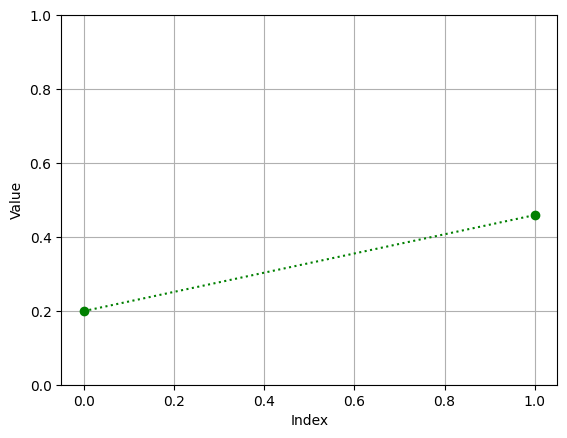

In [10]:

plt.plot(cka_score_list, color='green', linestyle=':', marker='o')  # color, dotted line, and dots for points

plt.xlabel('Index')
plt.ylabel('Value')
plt.ylim(0, 1)

plt.grid(True)

plt.show()

In [11]:
print(cka_score_list)

[0.19921875, 0.458984375]


In [12]:
# Linear CKA, between X and Y: 0.3921027743671094
# Linear CKA, between X and X: 1.0000000000000002
# RBF Kernel CKA, between X and Y: 0.5203295120301046
# RBF Kernel CKA, between X and X: 1.0 with numpy

In [13]:
# with numpy
# Linear CKA, between X and Y: 0.3921027743671094
# # Linear CKA, between X and X: 1.0000000000000002
# # RBF Kernel CKA, between X and Y: 0.5203295120301046
# # RBF Kernel CKA, between X and X: 1.0 

# #with torch
# torch.cuda.DoubleTensor
# Linear CKA, between X and Y: 0.3921027743671095
# Linear CKA, between X and X: 1.0
# RBF Kernel CKA, between X and Y: 0.5203309221903906
# RBF Kernel CKA, between X and X: 0.9999999999999999
